# Week 4 -- Statistical Analysis


There is significant debate among academics as to how a Likert scale responses should be interpreted --
[Likert items and scales of measurement? by James Dean Brown](https://hosted.jalt.org/test/PDF/Brown34.pdf).  Should the responses be score as we did in **Q4** of week 2?  Or should we look at the proporption of responses assigned to each choice for each respondent (or question)?

This week, we will perform the latter and work from the dataset created in **Q4** last week:

```roster_with_score.csv```

We will compare the survey results by department to the overall survey results to understand which departments may have better or worse morale.  To do this, we will use a $\chi^2$ Test to compare the responses on the Likert scale from each department to the firm's overall responses.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('roster_with_score.csv')
df = df.drop(columns=['Unnamed: 0'])
df.head(1)

,employee_id,title,last,first,manager_id,function,department,location,age,sex,...,employment_status,tenure,tenure_id,seniority,alignment,development,enablement,engagement,leadership,overall
0,343,CEO,Duran,Veronica,NaN,CEO,Leadership,"Mountain View, CA",35 - 44,F,...,Full time,1 to less than 2 years,2,4,0.8,0.666667,0.733333,0.68,0.733333,0.722667


## Q1: Compute the Expected Proportions

Let's assume we have labeled each response of the Likert scale as follows:

Label |  Description
--|--
1|strongly disagree
2| disagree
3| neutral
4| agree
5| strongly agree

Compute the expected proportion for each label (1 through 5) by respondent.

- Load the responses.csv dataset for your calculations
- Compute the expected proportion for each label on the Likert scale by respondent based on the overall population of respondents at LoanTronic.

In [3]:
# Load responses data
r_df = pd.read_csv('responses_clean.csv')
r_df.head(1)

,employee_id,question_id,answer,score
0,343,1,4,0.8


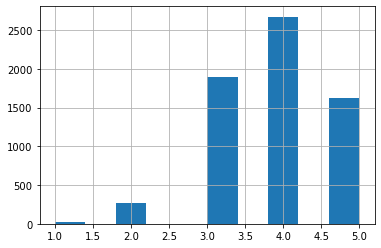

In [107]:
# Review proportion of responses
r_df.answer.hist();

```As we can see above, the data is clearly not normally distributed - it appears to be left-skewed (negative skew), meaning employees tend to favor higher responses over lower ones.```

In [85]:
# Create dataframe of expected answer proportions
expected = pd.DataFrame(r_df.answer.value_counts())
total = expected.answer.sum()
expected.answer = expected.answer / total
expected.columns = ['expected']
expected.sort_index(inplace=True)
expected

,expected
1,0.002933
2,0.041532
3,0.292728
4,0.412382
5,0.250425


## Q2: Compute the Expected Count by Department

Create a new dataframe where you group by department and compute the expected count for each label (1 through 5).

In [28]:
# Merge department data to responses and summarize answers
m_df = df.merge(r_df, on='employee_id')
g_df = m_df.groupby(['department','answer'], as_index=False)['employee_id'].count()
g_df.rename(columns={'employee_id':'count'}, inplace=True)

In [30]:
# Get all iterations of answer / department and merge
da_df = pd.DataFrame(list(zip(sorted(g_df['department'].unique().tolist() * 5), g_df['answer'].unique().tolist() * len(g_df['department'].unique()))), columns=['department','answer'])
g_df = da_df.merge(g_df, on=['department','answer'], how='left')

# Check sample of departments with missing answers
g_df[g_df['count'].isna()].head()

,department,answer,count
4,Advanced Technology,1,NaN
25,East Coast Lender Relations,2,NaN
29,East Coast Lender Relations,1,NaN
34,East Coast Lending,1,NaN
39,Engineering,1,NaN


In [31]:
# Calculate department totals for actual proportions
g_df.fillna(0, inplace=True)
t_df = g_df.groupby('department')['count'].sum()
g_df = g_df.merge(t_df, on='department', suffixes=('','_tot'))
g_df['actual'] = g_df['count'] / g_df['count_tot']

In [32]:
# Merge expected proportions to the summarized data
g_df = g_df.merge(expected, left_on='answer', right_index=True)
g_df['count_exp'] = g_df['expected'] * g_df['count_tot']
g_df.head(3)

,department,answer,count,count_tot,actual,expected,count_exp
0,Advanced Technology,2,2.0,34.0,0.058824,0.041532,1.412073
5,Algorithm Development,2,17.0,782.0,0.021739,0.041532,32.477690
10,Back End,2,20.0,323.0,0.061920,0.041532,13.414698


## Q3: Compute the $\chi^2$ Test

Now let's compute the $\chi^2$ Test Statistic by department. To do so, let's answer the following:

a) What are the degrees of freedom (k and p) to be used for each test (hint: you should keep track of the number of respondents by department)?
    
```Degrees of freedom would be the number of categories (k) - 1, or 5 - 1 = 4. Respondents by department is not relevant.```

```We should use a p-statistic (alpha) of 0.05 as the standard significance level, divided by 2 for a 2-tailed test```

b) Build a function to compute the $\chi^2$ test statistic and apply that function to each user?

c) Let's assume our Null Hypothesis $H_0$ is that each department is the same as the overall population.  Identify which department's responses suggest we should reject the Null Hypothesis.


In [66]:
# Observations with expected counts below chisquare threshold
below = g_df[g_df.count_exp < 5]
print(f'{len(below)} observations below threshold')
print(f'{len(below.department.unique())} departments with potentially skewed statistics')

# Summary of answers with expected counts below assumed threshold for chisquare
below.groupby('answer')['count'].count()

60 observations below threshold
36 departments with potentially skewed statistics


answer
1    36
2    18
3     3
5     3
Name: count, dtype: int64

### Small Samples

```Because the expected count of '1' answers is below the threshold for all departments, I will remove it from the population for calculation of the statistics and compare the p values to avoid the risk of skewed results```

In [87]:
from scipy.stats import chisquare

# Function to apply chi squared test and print results
def chi_stat(d, df, a):
    stat = chisquare(df['count'], df.count_exp).pvalue
    conclusion = ('Fail to ' if stat >= a else '') + 'reject the null hypothesis'
    print(f"{d} x2 p value = {stat:.2f}, conclusion: {conclusion}")
    return stat

# Run function for each department and store results
a = 0.05 / 2
results = {}
for d in g_df.department.unique():
    d_df = g_df[g_df.department == d]
    results[d] = chi_stat(d, d_df, a)
    results[d+'_ex'] = chi_stat(d+'_ex', d_df[d_df.answer != 1], a)

Advanced Technology x2 p value = 0.96, conclusion: Fail to reject the null hypothesis
Advanced Technology_ex x2 p value = 0.96, conclusion: Fail to reject the null hypothesis
Algorithm Development x2 p value = 0.00, conclusion: reject the null hypothesis
Algorithm Development_ex x2 p value = 0.00, conclusion: reject the null hypothesis
Back End x2 p value = 0.12, conclusion: Fail to reject the null hypothesis
Back End_ex x2 p value = 0.12, conclusion: Fail to reject the null hypothesis
Channel Marketing x2 p value = 0.48, conclusion: Fail to reject the null hypothesis
Channel Marketing_ex x2 p value = 0.48, conclusion: Fail to reject the null hypothesis
Compliance x2 p value = 0.02, conclusion: reject the null hypothesis
Compliance_ex x2 p value = 0.02, conclusion: reject the null hypothesis
East Coast Lender Relations x2 p value = 0.84, conclusion: Fail to reject the null hypothesis
East Coast Lender Relations_ex x2 p value = 0.84, conclusion: Fail to reject the null hypothesis
East C

In [98]:
final = pd.Series(results)
final2 = final[final.index.str.endswith('_ex')]
final = final[~final.index.str.endswith('_ex')]
reject = final[final < a]
print(f'{len(reject)} of {len(final)} departments significantly differed from the expected distribution')
reject

11 of 36 departments significantly differed from the expected distribution


Algorithm Development    3.508830e-03
Compliance               1.806221e-02
East Coast Lending       1.070853e-02
FHA Loans                9.605091e-03
Finance                  1.641344e-04
Front End                7.024202e-03
Full Stack               4.383692e-03
Midwest Lending          1.604690e-05
South Lending            2.946857e-06
Southwest Lending        5.435609e-07
VA Loans                 6.876369e-04
dtype: float64

In [104]:
# Compare calculation with all answers vs. exclusion of '1'
final2.index = final.index
comp = pd.DataFrame({'all':final,'excl':final2})
comp['diff'] = comp['all'] - comp.excl
comp.sort_values('diff', ascending=False).head()

,all,excl,diff
Advanced Technology,0.964454,0.964454,0.0
Algorithm Development,0.003509,0.003509,0.0
Midwest Lender Relations,0.178722,0.178722,0.0
Midwest Lending,0.000016,0.000016,0.0
New Home Purchase,0.589692,0.589692,0.0


```It would appear that excluding the '1' responses made no difference on our values! Therefore, we will use them all.```

## Q4: Good and Bad

Go through the results from **Q3** to identify:

a) which departments are significantly over-performing in terms of the survey metrics, and  

b) which ones are significantly under-performing.

```To determine under / over performing departments, I will calculate a weighted average of the likert responses by multiplying the answer value by the observed and expected proportions of responses. Over-performing departments will display higher averages than expected, while under-performing departments will display lower averages.```

In [70]:
# Compute weighted average likert observed
rj_df = g_df.merge(pd.DataFrame(reject), left_on='department', right_index=True)
rj_df['imputed'] = rj_df.answer * rj_df.actual
fnl_df = rj_df.groupby('department', as_index=False)['imputed'].sum()
fnl_df.head(1)

,department,imputed
0,Algorithm Development,3.959079


In [74]:
# Weighted average likert expected
expected['impute'] = expected.index * expected.expected
fnl_df['expected'] = expected.impute.sum()
fnl_df.head(3)

<ipython-input-74-99ac92656205>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expected['impute'] = expected.index * expected.expected


,department,imputed,expected
0,Algorithm Development,3.959079,3.862899
1,Compliance,3.919786,3.862899
2,East Coast Lending,3.730392,3.862899


In [72]:
# Departments significantly over-performing
op_df = fnl_df[fnl_df['imputed'] > fnl_df['expected']].sort_values('imputed', ascending=False)
print(f'{len(op_df)} departments are considered overperforming')
op_df.head()

4 departments are considered overperforming


,department,imputed,expected
6,Full Stack,3.985653,3.865833
5,Front End,3.983193,3.865833
0,Algorithm Development,3.959079,3.865833
1,Compliance,3.919786,3.865833


In [73]:
# Departments significantly under-performing
up_df = fnl_df[fnl_df['imputed'] < fnl_df['expected']].sort_values('imputed')
print(f'{len(up_df)} departments are considered underperforming')
up_df.head()

7 departments are considered underperforming


,department,imputed,expected
8,South Lending,3.411765,3.865833
7,Midwest Lending,3.463235,3.865833
9,Southwest Lending,3.485294,3.865833
3,FHA Loans,3.575163,3.865833
10,VA Loans,3.578431,3.865833


In [ ]:
!jupyter nbconvert --to html --template full LoanTronic_Statistics.ipynb